# Generate Synthetic Data

In [1]:
from act.SyntheticGenerator import SyntheticGenerator
from act.act_types import SimParams, OptimizationParameters
from act.cell_model import TargetCell, ModuleParameters

random_seed = 62
module_name = f"spiker_seg_{random_seed}"

target_cell = TargetCell(
    hoc_file="/home/mwsrgf/proj/ACT/data/Spiker/seg/template.hoc",
    mod_folder="/home/mwsrgf/proj/ACT/data/Spiker/seg",
    cell_name="Simple_Spiker_seg",
    g_names = ["gnabar_hh_seg", "gkbar_hh_seg", "gl_hh_seg"]
)

sim_par= SimParams(
            h_v_init=-65.0,  # Consistent with nrngui settings
            h_tstop=500,     # Simulation time in ms
            h_dt=0.1,      # Time step in ms
            h_celsius=6.3,   # Temperature in degrees Celsius
            CI_type="constant",
            CI_amps=[0.1,0.2,0.3],   # Current injection amplitude
            CI_dur=300,      # Duration of current injection
            CI_delay=100,     # Delay before current injection
            set_g_to=[]
        )

sg = SyntheticGenerator(
    ModuleParameters(
        module_folder_name=module_name,
        cell= target_cell,
        sim_params= sim_par,
        optim_params = OptimizationParameters(
            blocked_channels= []
        )
    )
)

sg.generate_synthetic_target_data("target_data.csv")

/home/mwsrgf/act-venv/lib64/python3.9/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
--No graphics will be displayed.


Blocking: []
Total number of jobs: 3
Total number of proccessors: 192
/home/mwsrgf/proj/ACT/model/spiker_seg_62/synthetic_0.1_0.2_0.3_


(5000,)


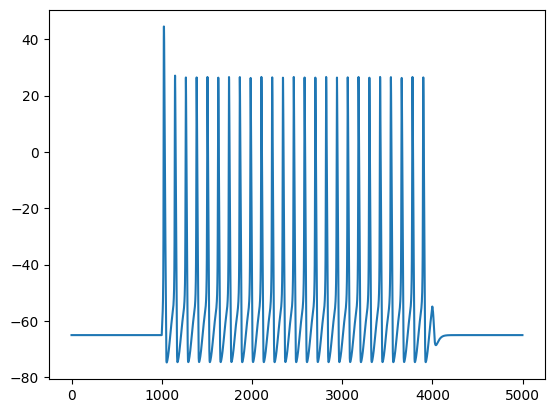

In [2]:
import numpy as np
dataset = np.load(f"./model/{module_name}/synthetic_0.1_0.2_0.3_/combined_out.npy")

V = dataset[0,:,0]
print(V.shape)

from matplotlib import pyplot as plt

plt.plot(V)

In [3]:
passive_sim_par = SimParams(
            h_v_init = -65,
            h_tstop = 500,
            h_dt = 0.1,
            h_celsius = 6.3,
            CI_type = "constant",
            CI_amps = [-0.1],    ##################### NEGATIVE CURRENT INJECTION ###################
            CI_dur = 300,
            CI_delay = 100,
            set_g_to=[]
        )

sg_passive = SyntheticGenerator(
    ModuleParameters(
        module_folder_name=module_name,
        cell= target_cell,
        sim_params= passive_sim_par,
        optim_params = OptimizationParameters(
            blocked_channels= []
        )
    )
)

sg_passive.generate_synthetic_target_data("passive_data.csv")

Blocking: []
Total number of jobs: 1
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/model/spiker_seg_62/synthetic_-0.1_


(5000,)


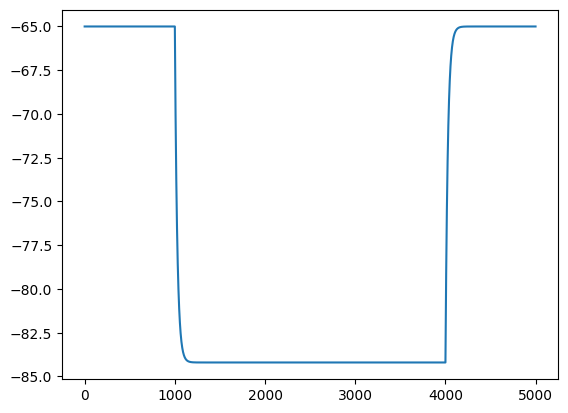

In [4]:
import numpy as np
dataset = np.loadtxt('./model/spiker_segregated/target/passive_data.csv', delimiter=',', skiprows=1)

V = dataset[:,0]
print(V.shape)

from matplotlib import pyplot as plt

plt.plot(V)

# Get Passive Properties

In [5]:
from act.PassivePropertiesModule import PassivePropertiesModule
from act.act_types import SimParams
from act.cell_model import TrainCell

train_cell = TrainCell(
    hoc_file="/home/mwsrgf/proj/ACT/data/Spiker/seg/template.hoc",
    mod_folder="/home/mwsrgf/proj/ACT/data/Spiker/seg",
    cell_name="Simple_Spiker_seg",
    g_names = ["gnabar_hh_seg", "gkbar_hh_seg", "gl_hh_seg"]
)

passive_mod = PassivePropertiesModule(
    train_cell=train_cell,
    sim_params=passive_sim_par,
    trace_filepath=f"./model/{module_name}/target/passive_data.csv",
    leak_conductance_variable="gl_hh_seg",
    leak_reversal_variable="el_hh_seg"
)

In [6]:
passive_mod.set_passive_properties()
print(train_cell.passive_properties)

MECHANISMS already loaded.
Found 1 section(s) in this cell. Calculating the total surface area of the cell.
PassiveProperties(V_rest=-65.0, R_in=191.99802919980584, tau=2.7, Cm=1.2664890000000124, g_bar_leak=0.00046907000000000453, cell_area=1.1103645074847766e-05, leak_conductance_variable='gl_hh_seg', leak_reversal_variable='el_hh_seg')


# Run Original Pipeline with Passive Prediction

In [7]:
from act.ACTModule import ACTModule
from act.SyntheticGenerator import SyntheticGenerator
from act.act_types import  Cell, SimParams, OptimizationParameters, OptimizationParam
from act.cell_model import ModuleParameters
from act.PassivePropertiesModule import PassivePropertiesModule
from act.act_types import SimParams
from act.cell_model import TrainCell

mod = ACTModule(
    ModuleParameters(
        module_folder_name=module_name,
        cell= train_cell,
        target_traces_file = "target_data.csv",
        sim_params= sim_par,
        optim_params= OptimizationParameters(
            g_ranges_slices= [
                OptimizationParam(param="gnabar_hh_seg", low=0.06, high=0.18, n_slices=25),
                OptimizationParam(param="gkbar_hh_seg", low=0.018, high=0.054, n_slices=25),
                OptimizationParam(param="gl_hh_seg", prediction=train_cell.passive_properties.g_bar_leak, bounds_variation=0.0, n_slices=1),
                
            ],
            prediction_eval_method='fi_curve',
            random_state=random_seed,
            save_file= "model/" + module_name + "/results/saved_metrics.json"
        )
    )
)

In [8]:
predicted_g_data_file = mod.run()

RUNNING THE MODULE
LOADING TARGET TRACES
SIMULATING TRAINING DATA
Total number of jobs: 1875
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/model/spiker_seg_62/train
TRAINING RANDOM FOREST REGRESSOR
-------------------------------------------------
GENERATING ARIMA STATS
-------------------------------------------------
ARIMA order set to (4, 0, 4)


100%|██████████| 3/3 [00:05<00:00,  1.87s/it]
/home/mwsrgf/act-venv/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mwsrgf/act-venv/lib64/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mwsrgf/proj/ACT/act/DataProcessor.py:428: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(num_spikes_list), np.array(interspike_times_list), np.array(mean_interspike_times_list),first_n_spikes_final, np.array(avg_spike_min_list), np.array(avg_spike_max_list)


-------------------------------------------------
GENERATING ARIMA STATS
-------------------------------------------------
ARIMA order set to (4, 0, 4)


100%|██████████| 1875/1875 [15:58<00:00,  1.96it/s]


Extracting features: ['I_mean', 'I_stdev', 'Num Spikes', 'Interspike Interval', 'Avg Min Spike Height', 'Avg Max Spike Height', 'V_mean', 'amplitude', 'frequency', 'arima0', 'arima1', 'arima2', 'arima3', 'arima4', 'arima5', 'arima6', 'arima7', 'arima8', 'arima9']
Evaluating random forest
MAE: 0.001092 (0.000085)
Saving rf mean/stdev scores to model/spiker_seg_62/results/saved_metrics.json
Predicted Conductances for each current injection intensity: 
[[0.12924    0.041088   0.00046907]
 [0.13028    0.040365   0.00046907]
 [0.125615   0.038628   0.00046907]]
SIMULATING PREDICTIONS
Total number of jobs: 9
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/model/spiker_seg_62/prediction_eval0
/home/mwsrgf/proj/ACT/model/spiker_seg_62/prediction_eval1
/home/mwsrgf/proj/ACT/model/spiker_seg_62/prediction_eval2
SELECTING BEST PREDICTION
FI curve MAE for each prediction: 
[2.2222222222222237, 2.2222222222222237, 2.2222222222222237]
{'gnabar_hh_seg': 0.12923999999

In [9]:
mod.pickle_rf(mod.rf_model,f"./model/{module_name}/trained_rf.pkl")

In [10]:
from act import ACTPlot
ACTPlot.plot_v_comparison(predicted_g_data_file, f"./model/{module_name}/target", f"./model/{module_name}", sim_par["CI_amps"])
ACTPlot.plot_fi_comparison(f"./model/{module_name}/results/frequency_data.npy", sim_par["CI_amps"])

# Closer Look

In [11]:
from act.Metrics import Metrics

metrics = Metrics()

mean, stdev = metrics.print_interspike_interval_comparison(
    f"./model/{module_name}/prediction_eval1/combined_out.npy",
    f"./model/{module_name}/target/combined_out.npy", 
    [0.1,0.2,0.3], 
    5,
    0.1,
    save_file="model/" + module_name + "/results/saved_metrics.json"
)

Interspike times (Target): [[12.4 12.  12.  11.9 12. ]
 [11.2 10.7 10.7 10.7 10.6]
 [10.6 10.   9.9 10.   9.9]]
Interspike times (Prediction): [[12.3 11.9 11.9 11.9 11.8]
 [11.1 10.7 10.7 10.6 10.6]
 [10.7 10.1 10.  10.1 10. ]]
MAE for each I injection: [0.09999999999999964, 0.09999999999999964, 0.09999999999999964]
Mean interspike-interval MAE: 0.09999999999999964
Standard Deviation interspike-interval MAE: 0.0


In [12]:
from act.DataProcessor import DataProcessor
import numpy as np

dp = DataProcessor()

# Get Target Cell Frequencies
dataset = np.load(f"./model/{module_name}/target/combined_out.npy")

V_target = dataset[:,:,0]

target_frequencies = dp.get_fi_curve(V_target, sim_par["CI_amps"], inj_dur=300).flatten()
print(target_frequencies)

[ 83.33333333  96.66666667 103.33333333]


/home/mwsrgf/act-venv/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mwsrgf/act-venv/lib64/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mwsrgf/proj/ACT/act/DataProcessor.py:428: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(num_spikes_list), np.array(interspike_times_list), np.array(mean_interspike_times_list),first_n_spikes_final, np.array(avg_spike_min_list), np.array(avg_spike_max_list)


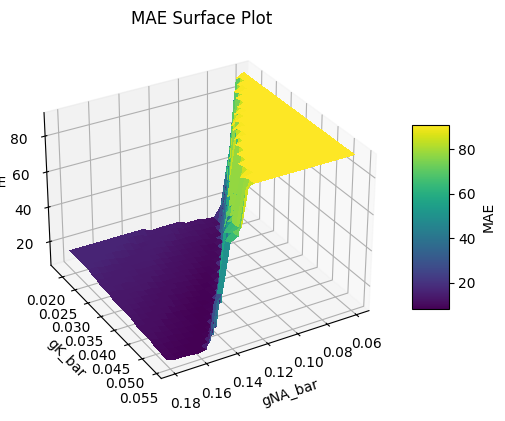

In [13]:
import os
import numpy as np
from matplotlib import pyplot as plt

from act.DataProcessor import DataProcessor
from act.Metrics import Metrics
from matplotlib import cm

from act import ACTPlot as actplt

actplt.plot_training_fi_mae_surface_spiker_cell(
f"./model/{module_name}/target/combined_out.npy",
f"./model/{module_name}/train/combined_out.npy",
sim_par["CI_amps"],
300,
100,
0.1,
f"./model/{module_name}/results/FI_MAE_Surface.html",
)

/home/mwsrgf/act-venv/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/home/mwsrgf/act-venv/lib64/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/home/mwsrgf/proj/ACT/act/DataProcessor.py:428: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Smallest MAE values (gNa, gK, MAE): 
[[0.16       0.054      7.77777778]
 [0.155      0.0495     8.14814815]
 [0.15       0.051      8.14814815]
 [0.15       0.0495     8.14814815]
 [0.15       0.048      8.14814815]
 [0.13       0.0405     8.14814815]]


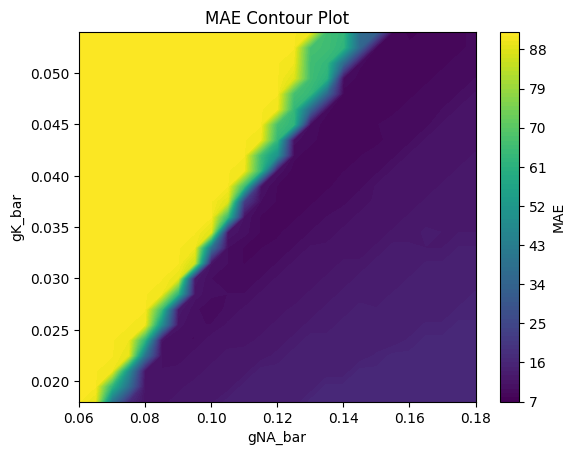

In [14]:
from act import ACTPlot as actplt

actplt.plot_training_fi_mae_contour_plot(
f"./model/{module_name}/target/combined_out.npy",
f"./model/{module_name}/train/combined_out.npy",
[0.1,0.2,0.3],#sim_par["CI_amps"],
300,
100,
0.1,
100,
f"./model/{module_name}/results/contour_map.png",
)

found indices: 625
found indices: 625
found indices: 625


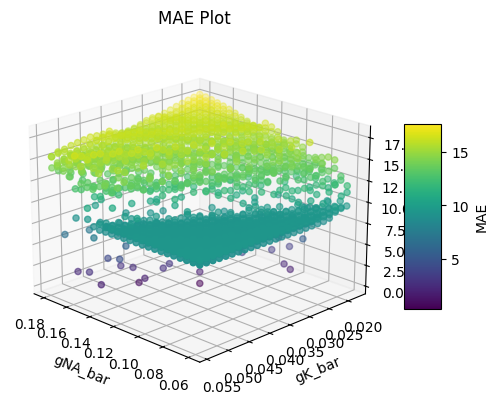

In [15]:
from act import ACTPlot as actplt

actplt.plot_training_v_mae_scatter_spiker_cell(
    f"./model/{module_name}/target/combined_out.npy",
    f"./model/{module_name}/train/combined_out.npy",
    100,
    0.1
)
